# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [4]:
# import libraries
import pandas as pd
from sqlalchemy import create_engine
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Boris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Boris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('messages_categories', engine)

df.head(3)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Extract features (X) and output (Y)

In [6]:
# Categories Columnn names  
categories_cols = df.columns[4:].tolist()

X = df['message']
Y = df[categories_cols]

### 2. Write a tokenization function to process your text data

In [7]:
def tokenize(text):
    # Normalize text: leave decapitalized letters and digits only
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # Split into words
    words = text.split()
    
    # Remove stop words
    words = [w for w in words if w not in stopwords.words("english")]
    
    # Reduce words to their root form
    lemmed = [WordNetLemmatizer().lemmatize(w) for w in words]
    
    # Reduce words to their stems
    stemmed = [PorterStemmer().stem(w) for w in lemmed]
    
    return stemmed

In [8]:
# Test tokenize (use 5 first message texts)

for i in range(5):
    text = X[i]
    print("Source text:\n" + text)
    tokens = tokenize(text)
    print("Tokens:\n" + str(tokens))
    print("------------------------------")

Source text:
Weather update - a cold front from Cuba that could pass over Haiti
Tokens:
['weather', 'updat', 'cold', 'front', 'cuba', 'could', 'pa', 'haiti']
------------------------------
Source text:
Is the Hurricane over or is it not over
Tokens:
['hurrican']
------------------------------
Source text:
Looking for someone but no name
Tokens:
['look', 'someon', 'name']
------------------------------
Source text:
UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.
Tokens:
['un', 'report', 'leogan', '80', '90', 'destroy', 'hospit', 'st', 'croix', 'function', 'need', 'suppli', 'desper']
------------------------------
Source text:
says: west side of Haiti, rest of the country today and tonight
Tokens:
['say', 'west', 'side', 'haiti', 'rest', 'countri', 'today', 'tonight']
------------------------------


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [11]:
classifier = RandomForestClassifier(n_estimators=8)

pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
                    ('forest', MultiOutputClassifier(classifier))
                    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [73]:
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                  

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

First, I will define a function that will compute _predictions_ on test and train data, and compare _average_ scores (accuracy, precision recall and F1). 

In [16]:
def test_model(model, X_train, X_test, Y_train, Y_test):
    '''
    Test the multi-class model on test and train data
    :param model   : scikit-learn estimator : fitted estimator
    :param X_train : array-like : train set of explanatory variables  
    :param X_test  : array-like : test set of explanatory variables 
    :param Y_train : array-like : train set of target variables  
    :param Y_test  : array-like : test set of target variables 
    
    :return: array-like : predicted test and train values
    '''
    Y_pred_train = model.predict(X_train)
    Y_pred_test  = model.predict(X_test)
    
    print('==========  Test Data Scores ===========')
    print('Accuracy: ', accuracy_score(Y_test, Y_pred_test))
    print('Precision: ', precision_score(Y_test, Y_pred_test, average='weighted'))
    print('Recall: ', recall_score(Y_test, Y_pred_test, average='weighted'))
    print('F1 score: ', f1_score(Y_test, Y_pred_test, average='weighted'))
    
    print('\n==========  Train Data Scores ===========')
    print('Accuracy: ', accuracy_score(Y_train, Y_pred_train))
    print('Precision: ', precision_score(Y_train, Y_pred_train, average='weighted'))
    print('Recall: ', recall_score(Y_train, Y_pred_train, average='weighted'))
    print('F1 score: ', f1_score(Y_train, Y_pred_train, average='weighted'))
    
    return Y_pred_test, Y_pred_train

In [75]:
Y_pred_test, Y_pred_train = test_model(pipeline, X_train, X_test, Y_train, Y_test)

==========  Test Data Scores ===========
Accuracy:  0.23959426372857642
Precision:  0.724821895546415
Recall:  0.4725485929794024
F1 score:  0.5310867126869674

==========  Train Data Scores ===========
Accuracy:  0.7783712382265104
Precision: 

D:\Anaconda3\envs\data_sci\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 0.9950746657857416
Recall:  0.9039902958322772
F1 score:  0.9450154922687994


We see that _train_ scores are much higher that _test_ scores. This means that we have a rather over-fitted model. 

Now let's compute f1 score, precision and recall for each output category of the dataset.

In [76]:
for i, col in enumerate(Y_test):
    print(col)
    print(classification_report(Y_test[col], Y_pred_test[:, i]))
    print("----------------------------------------------")

related
              precision    recall  f1-score   support

           0       0.60      0.47      0.53      2023
           1       0.85      0.90      0.87      6554

    accuracy                           0.80      8577
   macro avg       0.72      0.69      0.70      8577
weighted avg       0.79      0.80      0.79      8577

----------------------------------------------
request
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      7084
           1       0.82      0.41      0.54      1493

    accuracy                           0.88      8577
   macro avg       0.85      0.69      0.74      8577
weighted avg       0.87      0.88      0.86      8577

----------------------------------------------
offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8536
           1       0.00      0.00      0.00        41

    accuracy                           1.00      8577
   macro avg

D:\Anaconda3\envs\data_sci\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



----------------------------------------------
electricity
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8390
           1       0.43      0.02      0.03       187

    accuracy                           0.98      8577
   macro avg       0.70      0.51      0.51      8577
weighted avg       0.97      0.98      0.97      8577

----------------------------------------------
tools
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8518
           1       0.00      0.00      0.00        59

    accuracy                           0.99      8577
   macro avg       0.50      0.50      0.50      8577
weighted avg       0.99      0.99      0.99      8577

----------------------------------------------
hospitals
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8490
           1       0.00      0.00      0.00        87

    accuracy

#### Make reports for each score type (precision, recall, f1-score):
Obtain a DataFrame with `category` as index; each row should contain score values for test samples belonging (1), and not belonging (0) to this category. 

`score_report` function will be defined for obtaining such reports

In [77]:
def score_report(Y, Y_pred, score_type, skip_categories=['child_alone']):
    '''
    Produce a report for a given score type
    
    :param Y : array-like : test set of target variables
    :param Y_test : array-like : test set of target variables
    :param score_type : string : may be 'precision' or 'recall' or 'f1-score'
    :param skip_categories : list of strings : which categories we do not want to include in our report.
        'child_alone' is default, since there are no examples of messages belonging to this category 
    :return: DataFrame: 'category' as index; each row holds 2 values: scores for samples belonging (1),
    and not belonging (0) to this category
    '''
    if not score_type in ['precision', 'recall', 'f1-score']:
        return
    
    report_df = pd.DataFrame()

    for i, category in enumerate(Y):
        if category in skip_categories:
            continue
        # get report for category 
        cat_report = classification_report(Y[category], Y_pred[:, i], output_dict=True)
        # get the part that concerns only score_type  
        cat_row = pd.DataFrame(cat_report).loc[score_type][:2]
        # add 'category' value
        cat_row['category'] = category 
        # append to final report
        report_df = report_df.append(cat_row, sort=False)

    # set 'category' as index and return resulting DataFrame
    return report_df.set_index(['category'])
    
    

In [78]:
# Make Precision report
precision_report = score_report(Y_test, Y_pred_test, 'precision')
precision_report.head(10)

,0,1
category,,
related,0.602266,0.847453
request,0.886706,0.818674
offer,0.995220,0.000000
aid_related,0.728586,0.750835
medical_help,0.922623,0.595960
medical_products,0.952783,0.785714
search_and_rescue,0.974158,0.520000
security,0.981456,0.666667
military,0.969236,0.535714


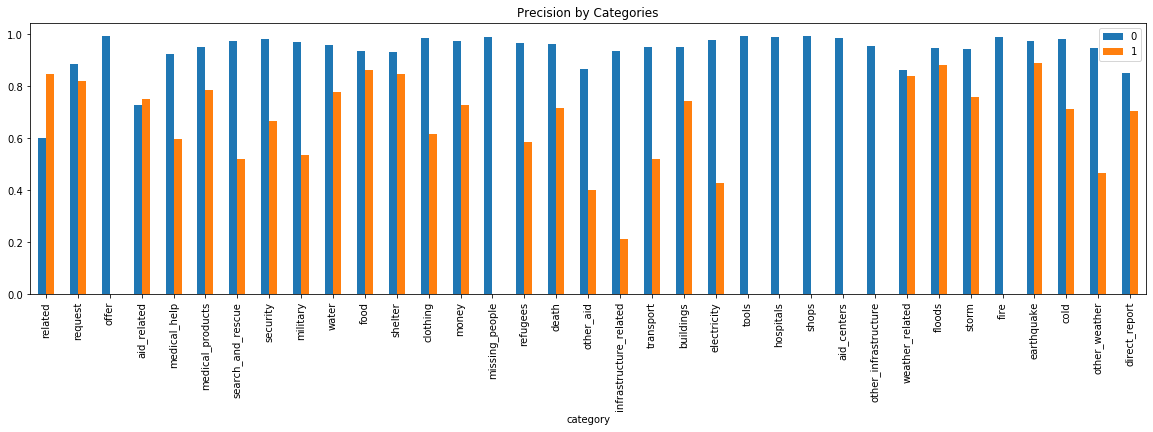

In [79]:
precision_report.plot.bar(title='Precision by Categories', figsize=(20,5));

D:\Anaconda3\envs\data_sci\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


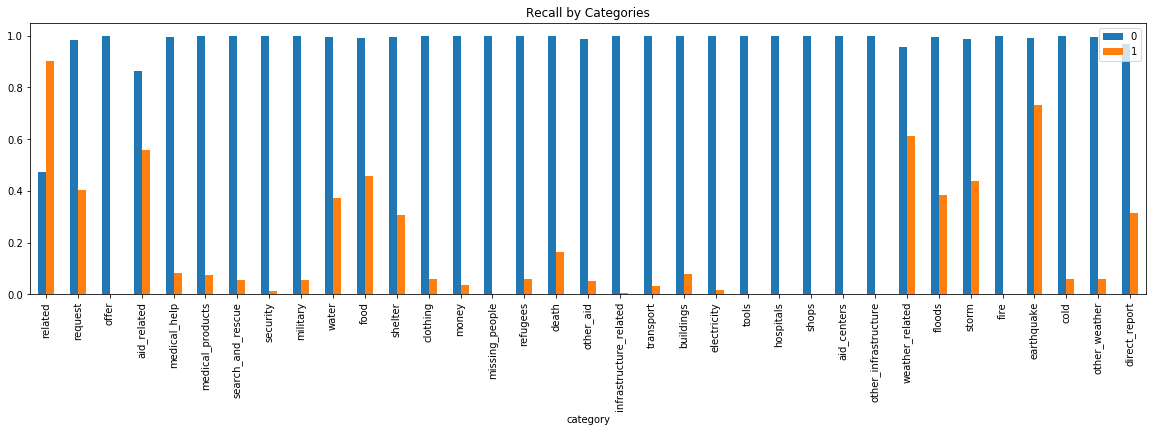

In [80]:
# Make Recall report
score_report(Y_test, Y_pred_test, 'recall').plot.bar(title='Recall by Categories', figsize=(20,5));

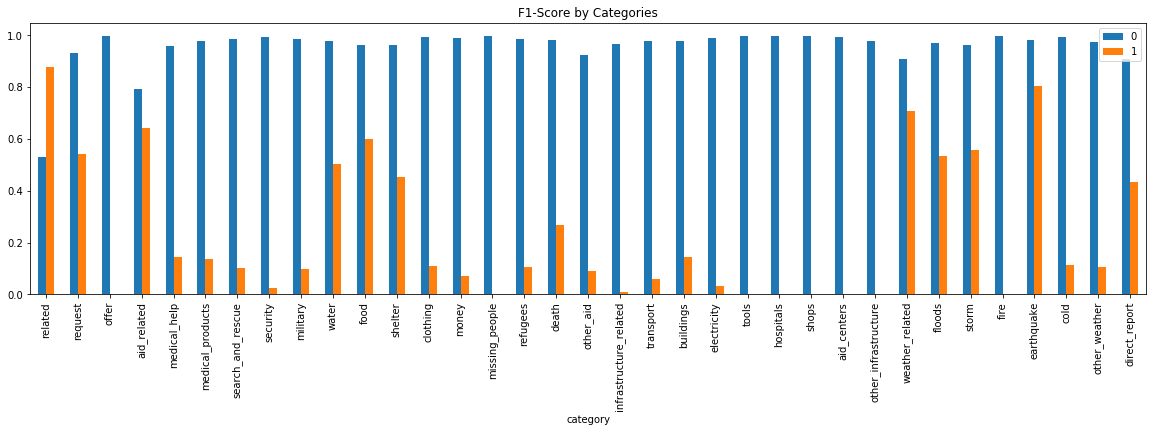

In [81]:
# Make F1-score report
score_report(Y_test, Y_pred_test, 'f1-score').plot.bar(title='F1-Score by Categories', figsize=(20,5));

For most categories, the class representation is severely disbalanced: too few positive examples. Hence we see that scores are much worse for positive test examples.  

### 6. Improve your model
Use grid search to find better parameters. 

In [83]:
parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'tfidf__max_df': (0.75, 1.0),
    'forest__estimator__n_estimators': [12, 20, 28],
    'forest__estimator__min_samples_split': [2, 4]
}

cv = GridSearchCV(pipeline, parameters, cv=3, verbose=3)


In [ ]:
cv.fit(X_train, Y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] forest__estimator__min_samples_split=2, forest__estimator__n_estimators=12, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  forest__estimator__min_samples_split=2, forest__estimator__n_estimators=12, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.243, total= 1.9min
[CV] forest__estimator__min_samples_split=2, forest__estimator__n_estimators=12, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV]  forest__estimator__min_samples_split=2, forest__estimator__n_estimators=12, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.250, total= 1.9min
[CV] forest__estimator__min_samples_split=2, forest__estimator__n_estimators=12, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


[CV]  forest__estimator__min_samples_split=2, forest__estimator__n_estimators=12, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.237, total= 1.9min
[CV] forest__estimator__min_samples_split=2, forest__estimator__n_estimators=12, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 
[CV]  forest__estimator__min_samples_split=2, forest__estimator__n_estimators=12, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.236, total= 2.2min
[CV] forest__estimator__min_samples_split=2, forest__estimator__n_estimators=12, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 
[CV]  forest__estimator__min_samples_split=2, forest__estimator__n_estimators=12, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.256, total= 2.2min
[CV] forest__estimator__min_samples_split=2, forest__estimator__n_estimators=12, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 
[CV]  forest__estimator__min_samples_split=2, forest__estimator__n_estimators=12, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.249, total=

[CV]  forest__estimator__min_samples_split=2, forest__estimator__n_estimators=28, tfidf__max_df=1.0, tfidf__ngram_range=(1, 1), score=0.255, total= 2.2min
[CV] forest__estimator__min_samples_split=2, forest__estimator__n_estimators=28, tfidf__max_df=1.0, tfidf__ngram_range=(1, 1) 
[CV]  forest__estimator__min_samples_split=2, forest__estimator__n_estimators=28, tfidf__max_df=1.0, tfidf__ngram_range=(1, 1), score=0.249, total= 2.2min
[CV] forest__estimator__min_samples_split=2, forest__estimator__n_estimators=28, tfidf__max_df=1.0, tfidf__ngram_range=(1, 2) 
[CV]  forest__estimator__min_samples_split=2, forest__estimator__n_estimators=28, tfidf__max_df=1.0, tfidf__ngram_range=(1, 2), score=0.250, total= 3.0min
[CV] forest__estimator__min_samples_split=2, forest__estimator__n_estimators=28, tfidf__max_df=1.0, tfidf__ngram_range=(1, 2) 
[CV]  forest__estimator__min_samples_split=2, forest__estimator__n_estimators=28, tfidf__max_df=1.0, tfidf__ngram_range=(1, 2), score=0.266, total= 3.0min

[CV]  forest__estimator__min_samples_split=4, forest__estimator__n_estimators=28, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.253, total= 2.2min
[CV] forest__estimator__min_samples_split=4, forest__estimator__n_estimators=28, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 
[CV]  forest__estimator__min_samples_split=4, forest__estimator__n_estimators=28, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.251, total= 2.1min
[CV] forest__estimator__min_samples_split=4, forest__estimator__n_estimators=28, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1) 
[CV]  forest__estimator__min_samples_split=4, forest__estimator__n_estimators=28, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), score=0.247, total= 2.1min
[CV] forest__estimator__min_samples_split=4, forest__estimator__n_estimators=28, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2) 
[CV]  forest__estimator__min_samples_split=4, forest__estimator__n_estimators=28, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), score=0.252, total=

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [18]:
Y_pred_test_cv, Y_pred_train_cv = test_model(cv, X_train, X_test, Y_train, Y_test)

==========  Test Data Scores ===========
Accuracy:  0.24915471610120088
Precision:  0.7447932538992399
Recall:  0.5036988685813751
F1 score:  0.5538814508253855

==========  Train Data Scores ===========
Accuracy:  0.8719848380427292


/Users/boris/anaconda3/envs/data_sci/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:  0.9973229641952617
Recall:  0.9503928739544484
F1 score:  0.9725385062458517


We see several percent improvement, which is sot very inpressive for F1 being ~0.5

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

The new pipeline will include:
- TF-IDF vectorizer
- Truncated SVD transformation to reduce the feature space dimensionality
- KNN classifier

In [13]:
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier()

pipeline_knn = Pipeline([
                    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
                    ('truncate', TruncatedSVD(n_components=32)),
                    ('knn', MultiOutputClassifier(knn_classifier))
                    ])


In [14]:
pipeline_knn.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                 tokenizer=<function tokenize at 0x00000190C63AD700>,
                                 use_idf=True, vocabulary=None)),
                ('truncate',
                 TruncatedSVD(algorithm='randomized', n_components=32, n_iter=5,
                              random_sta

In [17]:
test_model(pipeline_knn, X_train, X_test, Y_train, Y_test);

==========  Test Data Scores ===========
Accuracy:  0.23294858342077648
Precision:  0.6524783434237581
Recall:  0.47900348128807657
F1 score:  0.5289428382256647

==========  Train Data Scores ===========
Accuracy:  0.3479784056972203
Precision: 

D:\Anaconda3\envs\data_sci\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 0.8033262144139014
Recall:  0.5576456530397943
F1 score:  0.6208531092524379


In [19]:
    parameters_knn = {
        'tfidf__ngram_range': ((1, 1), (1, 2)),
        'tfidf__max_df': (0.75, 1.0),
        'truncate__n_components': [64, 128],
        'knn__estimator__n_neighbors': [1, 3]
    }

    knn_cv = GridSearchCV(pipeline_knn, parameters_knn, cv=3, verbose=3)

In [20]:
knn_cv.fit(X_train, Y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] knn__estimator__n_neighbors=1, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), truncate__n_components=64 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  knn__estimator__n_neighbors=1, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), truncate__n_components=64, score=0.216, total= 6.0min
[CV] knn__estimator__n_neighbors=1, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), truncate__n_components=64 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min remaining:    0.0s


[CV]  knn__estimator__n_neighbors=1, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), truncate__n_components=64, score=0.211, total= 6.3min
[CV] knn__estimator__n_neighbors=1, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), truncate__n_components=64 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.3min remaining:    0.0s


[CV]  knn__estimator__n_neighbors=1, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), truncate__n_components=64, score=0.214, total= 6.0min
[CV] knn__estimator__n_neighbors=1, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), truncate__n_components=128 
[CV]  knn__estimator__n_neighbors=1, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), truncate__n_components=128, score=0.209, total=10.8min
[CV] knn__estimator__n_neighbors=1, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), truncate__n_components=128 
[CV]  knn__estimator__n_neighbors=1, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), truncate__n_components=128, score=0.217, total=10.7min
[CV] knn__estimator__n_neighbors=1, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), truncate__n_components=128 
[CV]  knn__estimator__n_neighbors=1, tfidf__max_df=0.75, tfidf__ngram_range=(1, 1), truncate__n_components=128, score=0.219, total=10.9min
[CV] knn__estimator__n_neighbors=1, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), truncate__n_components=64 
[C

[CV]  knn__estimator__n_neighbors=3, tfidf__max_df=0.75, tfidf__ngram_range=(1, 2), truncate__n_components=128, score=0.252, total=10.9min
[CV] knn__estimator__n_neighbors=3, tfidf__max_df=1.0, tfidf__ngram_range=(1, 1), truncate__n_components=64 
[CV]  knn__estimator__n_neighbors=3, tfidf__max_df=1.0, tfidf__ngram_range=(1, 1), truncate__n_components=64, score=0.242, total= 6.1min
[CV] knn__estimator__n_neighbors=3, tfidf__max_df=1.0, tfidf__ngram_range=(1, 1), truncate__n_components=64 
[CV]  knn__estimator__n_neighbors=3, tfidf__max_df=1.0, tfidf__ngram_range=(1, 1), truncate__n_components=64, score=0.247, total= 5.3min
[CV] knn__estimator__n_neighbors=3, tfidf__max_df=1.0, tfidf__ngram_range=(1, 1), truncate__n_components=64 
[CV]  knn__estimator__n_neighbors=3, tfidf__max_df=1.0, tfidf__ngram_range=(1, 1), truncate__n_components=64, score=0.244, total= 5.1min
[CV] knn__estimator__n_neighbors=3, tfidf__max_df=1.0, tfidf__ngram_range=(1, 1), truncate__n_components=128 
[CV]  knn__es

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 397.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [21]:
test_model(knn_cv, X_train, X_test, Y_train, Y_test);

==========  Test Data Scores ===========
Accuracy:  0.2497376705141658
Precision:  0.6596527769592412
Recall:  0.452966347548593
F1 score:  0.5203990025835931

==========  Train Data Scores ===========
Accuracy:  0.42947392602802664
Precision:  0.8709023065564132
Recall:  0.5840605424195242
F1 score:  0.6727115368203482


We see that this model is not that much overfitted, but the scores on test set are not better than RandomForest results

Another try: Gradient Boosting Classifier

In [62]:
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier

gb_classifier = GradientBoostingClassifier(n_estimators = 64, random_state=42)

pipeline_gb = Pipeline([
                    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
                    ('truncate', TruncatedSVD(n_components=128)),
                    ('gb', MultiOutputClassifier(gb_classifier))
                    ])

In [63]:
pipeline_gb.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                                                                            loss='deviance',
                                                                            max_depth=3,
                                                                            max_features=None,
                         

In [65]:
test_model(pipeline_gb, X_train, X_test, Y_train, Y_test);

==========  Test Data Scores ===========
Accuracy:  0.22945085694298706
Precision:  0.6931443246245549
Recall:  0.5161372207716856
F1 score:  0.558619059009926

==========  Train Data Scores ===========
Accuracy:  0.28560762692396047
Precision:  0.8223476393193989
Recall:  0.5648332548792411
F1 score:  0.6225042604077646


### 9. Export your model as a pickle file

In [22]:
import joblib

joblib.dump(knn_cv.best_estimator_, 'disaster_model.pkl')

['disaster_model.pkl']

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.